In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
train_data = pd.read_csv('/content/drive/My Drive/uci_har_train_preprocessed.csv')
test_data = pd.read_csv('/content/drive/My Drive/uci_har_test_preprocessed.csv')

X_train = train_data.drop(columns=["label"])
y_train = train_data["label"]
X_test = test_data.drop(columns=["label"])
y_test = test_data["label"]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training labels:\n", y_train.value_counts())
print("Test labels:\n", y_test.value_counts())

Training data shape: (7352, 561)
Test data shape: (2947, 561)
Training labels:
 label
laying                1407
standing              1374
sitting               1286
walking               1226
walking_upstairs      1073
walking_downstairs     986
Name: count, dtype: int64
Test labels:
 label
laying                537
standing              532
walking               496
sitting               491
walking_upstairs      471
walking_downstairs    420
Name: count, dtype: int64


In [9]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

print("Reshaped training data shape:", X_train_reshaped.shape)
print("Reshaped test data shape:", X_test_reshaped.shape)

Reshaped training data shape: (7352, 1, 561)
Reshaped test data shape: (2947, 1, 561)


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Attention
)

input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

# Convolutional layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
conv1 = MaxPooling1D(pool_size=2, strides=2, padding='same')(conv1)  # Reduce length but retain sequence

conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv1)
conv2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(conv2)

# LSTM layers
lstm_out = LSTM(128, return_sequences=True)(conv2)
lstm_out = Dropout(0.3)(lstm_out)

# Self-attention layer
attention_output = Attention()([lstm_out, lstm_out])

# Additional LSTM layer
lstm_out_2 = LSTM(64, return_sequences=False)(attention_output)
lstm_out_2 = Dropout(0.3)(lstm_out_2)

# Fully connected layers
dense_1 = Dense(64, activation='relu')(lstm_out_2)
dense_1 = Dropout(0.3)(dense_1)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dense_1)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1, 561)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 1, 64)          │        107,776 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 1, 64)          │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 1, 128)         │         24,704 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 1, 128)         │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 1, 128)         │        131,584 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1, 128)         │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 1, 128)         │              0 │ dropout_2[0][0],       │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 64)             │         49,408 │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          4,160 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 6)              │            390 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 318,022 (1.21 MB)

 Trainable params: 318,022 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_reshaped, y_train_categorical,
    validation_data=(X_test_reshaped, y_test_categorical),
    epochs=25,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4026 - loss: 1.2969 - val_accuracy: 0.8694 - val_loss: 0.3468
Epoch 2/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8951 - loss: 0.2918 - val_accuracy: 0.9345 - val_loss: 0.1965
Epoch 3/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9593 - loss: 0.1249 - val_accuracy: 0.9220 - val_loss: 0.2407
Epoch 4/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9686 - loss: 0.1056 - val_accuracy: 0.9291 - val_loss: 0.2611
Epoch 5/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9734 - loss: 0.0811 - val_accuracy: 0.9410 - val_loss: 0.2229
Epoch 6/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9747 - loss: 0.0786 - val_accuracy: 0.9444 - val_loss: 0.2036
Epoch 7/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9797 - loss: 0.0653 - val_accuracy: 0.9491 - val_loss: 0.1752
Epoch 8/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9872 - loss: 0.0424 - val_accuracy: 0.945

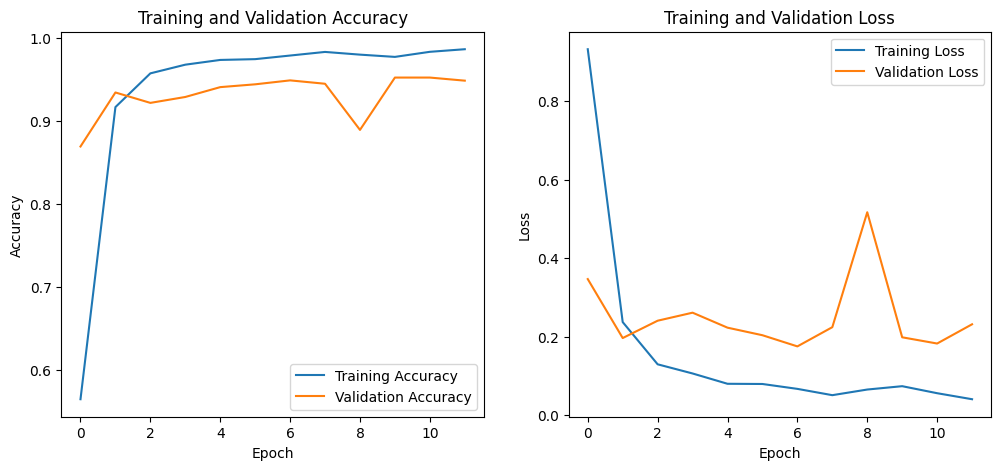

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_categorical)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9414 - loss: 0.1848
Test Loss: 0.17520155012607574
Test Accuracy: 0.9491007924079895


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
                    precision    recall  f1-score   support

            laying       1.00      0.99      1.00       537
           sitting       0.92      0.92      0.92       491
          standing       0.92      0.93      0.93       532
           walking       0.95      0.98      0.96       496
walking_downstairs       0.95      0.94      0.94       420
  walking_upstairs       0.96      0.92      0.94       471

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



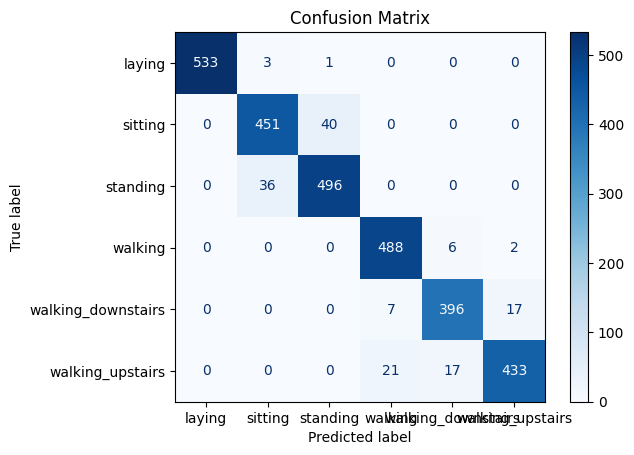

In [20]:
cm = confusion_matrix(y_test_encoded, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()